<a href="https://colab.research.google.com/github/ArashDehghanyan/ml-practicres/blob/main/Load_and_preprocess_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import PIL 
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

In [ ]:
print(tf.__version__)
print(tf.version.VERSION)

2.8.0
2.8.0


##Download Dataset

In [ ]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

data_dir = keras.utils.get_file(
    fname='flower_photos', origin=dataset_url, untar=True
)

data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 2s 0us/step


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


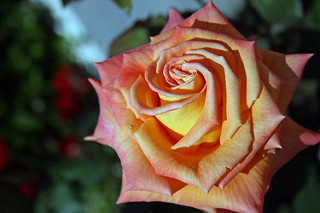

In [ ]:
roses = list(data_dir.glob('roses/*'))
Image.open(str(roses[2]))

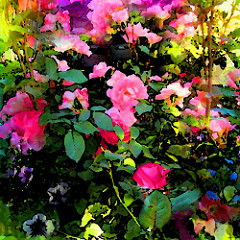

In [ ]:
Image.open(str(roses[4]))

In [ ]:
print(data_dir)

/root/.keras/datasets/flower_photos


##Load data using Keras utility

In [ ]:
# Define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

train_dataset = keras.utils.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset='training', seed=123, batch_size=batch_size, image_size=(img_height, img_width)
)

validation_dataset = keras.utils.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset="validation", seed=123, image_size=(img_height, img_width), batch_size=batch_size
)

class_names = train_dataset.class_names
print(class_names)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


##Visualize data

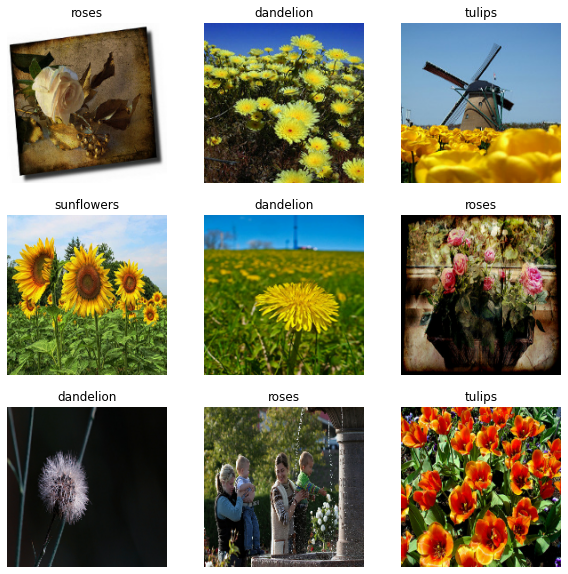

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
for image_batch, label_batch in train_dataset:
    print(image_batch.shape)
    print(label_batch.shape)
    break

(32, 180, 180, 3)
(32,)


##Data Standardization

In [ ]:
normalization_layer = layers.Rescaling(1. / 255)

In [ ]:
normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, label_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the values are in range [0, 1]
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


In [ ]:
AUTOMATE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOMATE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOMATE)

In [ ]:
num_classes = len(class_names)

model = keras.models.Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(32, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam', 
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

history = model.fit(train_dataset, validation_data=validation_dataset, epochs=3)

Epoch 1/3
92/92 [==============================] - 118s 1s/step - loss: 1.3566 - accuracy: 0.4227 - val_loss: 1.1308 - val_accuracy: 0.5477
Epoch 2/3
92/92 [==============================] - 106s 1s/step - loss: 1.0518 - accuracy: 0.5794 - val_loss: 0.9810 - val_accuracy: 0.6253
Epoch 3/3
92/92 [==============================] - 105s 1s/step - loss: 0.8910 - accuracy: 0.6482 - val_loss: 0.9681 - val_accuracy: 0.6253


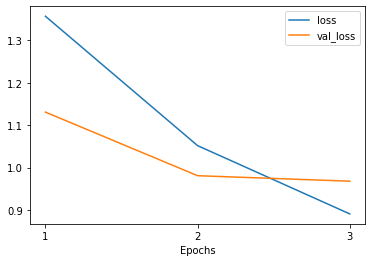

In [ ]:
from matplotlib import pyplot as plt

hist = history.history
epochs = list(np.add(history.epoch, 1))

plt.plot(epochs, hist['loss'], label='loss')
plt.plot(epochs, hist['val_loss'], label='val_loss')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.legend()
plt.show()

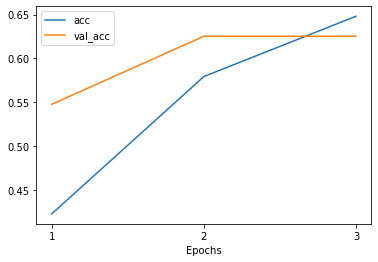

In [ ]:
plt.plot(epochs, hist['accuracy'], label='acc')
plt.plot(epochs, hist['val_accuracy'], label='val_acc')
plt.xlabel('Epochs')
plt.xticks(epochs)
plt.legend()
plt.show()

##Using tf.data for finer conrol

In [ ]:
list_dataset = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_dataset = list_dataset.shuffle(image_count, reshuffle_each_iteration=False)


In [ ]:
for f in list_dataset.take(5):
    print(f.numpy())
    

b'/root/.keras/datasets/flower_photos/dandelion/4574102507_70039c8b28.jpg'
b'/root/.keras/datasets/flower_photos/roses/2197754124_5c8a146761_n.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/14313509432_6f2343d6c8_m.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/22686342422_c0b9e2f38e.jpg'
b'/root/.keras/datasets/flower_photos/daisy/18711159980_11d3bd5042.jpg'


In [ ]:
# The tree structure of the files can be used to compile a class_names list
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != 'LICENSE.txt']))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


###Split dataset into training and validation sets

In [ ]:
validation_size = int(image_count * 0.2)
train_dataset = list_dataset.skip(validation_size)
validation_dataset = list_dataset.take(validation_size)

In [ ]:
# Print the length of each dataset
print(tf.data.experimental.cardinality(train_dataset).numpy())
print(tf.data.experimental.cardinality(validation_dataset).numpy())


2936
734


###**Convert a file path to a (img, label) pair**



In [ ]:
def get_label(file_path):
    # Convert a path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # Convert to one hot
    one_hot = parts[-2] == class_names
    # Convert to interger index
    return tf.argmax(one_hot)


def decode_img(img):
    # Covert a compressed string to a 3D unit8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image
    return tf.image.resize(img, [img_height, img_width])


def process_path(file_path):
    # get label
    label = get_label(file_path)
    # Read the data as a string
    img = tf.io.read_file(file_path)
    # decode string to a jpeg file
    img = decode_img(img)
    return img, label


In [ ]:
# Use dataset.map to create (img, label) pair 
# Set 'num_parallel_calls' so multiple images loaded/processed in parallel
train_dataset = train_dataset.map(process_path, num_parallel_calls=AUTOMATE)
validation_dataset = validation_dataset.map(process_path, num_parallel_calls=AUTOMATE)


In [ ]:
for image, label in train_dataset.take(1):
    print("image shape:", image.numpy().shape)
    print(label.numpy())

image shape: (180, 180, 3)
4


###Configure dataser for performance

In [ ]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOMATE)
    return ds

train_dataset = configure_for_performance(train_dataset)
validation_dataset = configure_for_performance(validation_dataset)


##Visualize the data

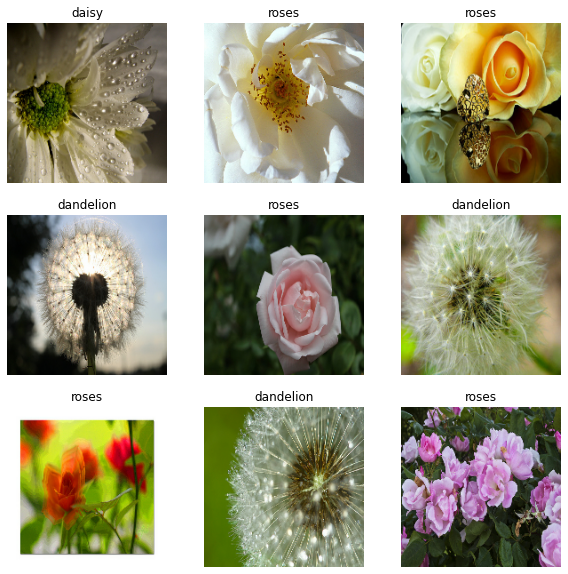

In [ ]:
image_batch, label_batch = next(iter(train_dataset))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis('off')

##Continue training model

In [ ]:
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=3,
)

Epoch 1/3
92/92 [==============================] - 125s 1s/step - loss: 0.7987 - accuracy: 0.6918 - val_loss: 0.6864 - val_accuracy: 0.7493
Epoch 2/3
92/92 [==============================] - 130s 1s/step - loss: 0.6180 - accuracy: 0.7776 - val_loss: 0.6619 - val_accuracy: 0.7398
Epoch 3/3
92/92 [==============================] - 158s 2s/step - loss: 0.4255 - accuracy: 0.8522 - val_loss: 0.6854 - val_accuracy: 0.7439


###Using tensorflow dataset

In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


5


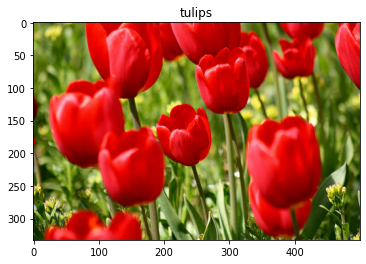

In [ ]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [ ]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)
